In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
labels = train_df['label']

# Drop 'label' column
images = train_df.drop(['label'],axis = 1)

# convert from [0:255] => [0.0:1.0] as CNN converg faster on [0..1] data than on [0..255].
images = images/255.0

test_df = test_df/255.0

In [5]:
# number of columns
image_size = images.shape[1]

# in this case all images are square
image_height = np.sqrt(image_size).astype(int)
image_width = image_height
print (image_height)

28


In [6]:
# Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one 
# channel. For RGB images, there is 3 channels.

# Reshape image in 3 dimensions (height , width , canal)
# -1 is required as another dimension to convert
images = images.values.reshape(-1,image_height,image_width,1)
test_df = test_df.values.reshape(-1,image_height,image_width,1)

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
labels = to_categorical(labels, num_classes = 10)
labels

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [8]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size = 0.1, random_state=2)

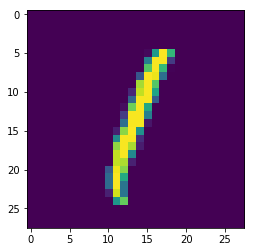

In [9]:
# Some examples
g = plt.imshow(X_train[7][:,:,0])

In [10]:
model = Sequential()

# with padding=Same output has the same length as the original input.
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation='relu',input_shape=(image_height,image_width,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [12]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# don't apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

C:\anaconda\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (37800, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [ ]:
# With the ReduceLROnPlateau function from Keras.callbacks, reduce the LR(learning rate) by half if the accuracy is not improved 
# after 3 epochs

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model
# set epoch =30 for good results
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 1, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] 
                              , callbacks=[learning_rate_reduction])

Epoch 1/1


In [ ]:
# predict results
results = model.predict(test_df)

# select the indices with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)